## Lecture 5 - Custom Estimators in TF ##
In this Lecture, We are going to create our custom estimator for deep learning.

In [1]:
import tensorflow as tf

# Plot drawing library
import matplotlib.pyplot as plt

# Make plots usable in notebook
%matplotlib inline

/Users/cihan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Prepare data ###
I will be using the same dataset with Lecture 3 and 4. We will have 2 features that will be used for model. Let's assume they are math and english scores for a student. We have 40 data points.

In [2]:
data = [[35, 40],[43, 30],[38, 31],[40, 40],[30, 50],[40, 60],[30, 50],[20, 60],[50, 50],[43, 50],
        [35, 40],[43, 30],[31, 21],[40, 60],[30, 50],[40, 60],[27, 67],[45, 54],[34, 43],[43, 40],
        [85, 90],[83, 80],[78, 91],[60, 90],[75, 85],[78, 80],[98, 80],[90, 60],[93, 83],[73, 93],
        [82, 94],[93, 62],[69, 75],[80, 60],[70, 90],[90, 60],[97, 67],[65, 84],[74, 95],[98, 83]]
labels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

### Let's see our data on a plot ###
We created a plot using Matplotlib. As you see, the green dots are the students who are accepted. Our classifier will detect if a new student is accepted or not.

[]

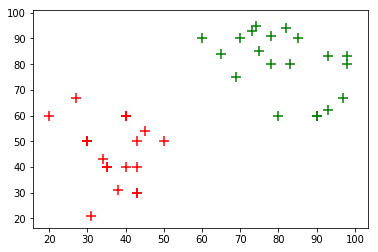

In [8]:
for i in range(len(data)):
    if labels[i] == 1:
        plt.scatter(data[i][0], data[i][1], s=120, marker='+', linewidths=2, color='green')
    else:
        plt.scatter(data[i][0], data[i][1], s=120, marker='+', linewidths=2, color='red')
plt.plot()

### Prepare input function ###
As we learned from Lecture 3, this function will run while running training function and put the data into the training process.

In [6]:
def input_func():
    global data 
    global labels
    mathArray, englishArray = [], []
    for data_point in data:
        mathArray.append(data_point[0])
        englishArray.append(data_point[1])
    feature_dict = {"math_score": mathArray, "english_score": englishArray}
    return feature_dict, labels

### Create Feature Columns ### 
As we learned from Lecture 3, we need some feature columns to use the data for training.

In [7]:
student_feature_columns = [tf.feature_column.numeric_column("math_score"), 
                           tf.feature_column.numeric_column("english_score")]

### Create a Model Function ###
In Lecture 3 and 4, we used  model functions created by Tensorflow Team, but now we can start to create our own models.

In [9]:
def DNNmodel(features, labels, mode, params):
    # This is the input layer that uses the features from input function
    net = tf.feature_column.input_layer(features, params["feature_columns"])
    
    # If you are creating a Deep Learning model, you can use tf.layers
    # for many layers that you need such as fully connected, convolutional, pooling and dropout.
    # tf.layers.dense is the fully connected layer. 
    for units in params["hidden_units"]:
        net = tf.layers.dense(net, units=units, activation=tf.nn.relu)
        
    # Compute logits for every class
    logits = tf.layers.dense(net, params["n_classes"], activation=None)
    
    # Compute the predictions of the net
    predicted_classes = tf.argmax(logits, 1)
    
    # Modes are used to implement training, evaluation, and prediction to the estimator.
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            "class_ids": predicted_classes[:, tf.newaxis],
            "probabilities": tf.nn.softmax(logits),
            "logits": logits
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    # Compute the Loss
    # For both training and evaluation, we will need a loss value.
    # This is what will we try to optimize.
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    # Compute evoluation metrics
    # This metric shows how accurate our model is.
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_classes, name="acc_op")
    
    metrics = {"accuracy": accuracy}
    
    # The tf.summary.scalar will make accuracy available to TensorBoard
    tf.summary.scalar("accuracy", accuracy[1])
    
    if mode == tf.estimator.ModeKeys.EVAL:
        # The EstimatorSpec contains the following info:
        # loss: model's loss
        # eval_metric_ops: An optional dictionary of metrics
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)
    
    # Optimizers are used in training to optimize the model using loss
    optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
    
    # Minimize loss using optimizer.minimize operation
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        #The EstimatorSpec for training must have the following:
        #loss:  the value comes from the loss function.
        #train_op: executes a training step.
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

### Create Custom Estimator using Model Function ###

In [10]:
CustomClassifier = tf.estimator.Estimator(model_fn=DNNmodel,
                                          params={
                                            "feature_columns": student_feature_columns,
                                            "hidden_units": [8, 8],
                                            "n_classes": 2
                                          })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/_7/c28_8vl522n4nj1h8x0r4m300000gn/T/tmpdmpnjhbe', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1819c04a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train The Custom Estimator ###

In [12]:
CustomClassifier.train(input_fn=input_func, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/_7/c28_8vl522n4nj1h8x0r4m300000gn/T/tmpdmpnjhbe/model.ckpt.
INFO:tensorflow:loss = 20.148813, step = 1
INFO:tensorflow:global_step/sec: 552.08
INFO:tensorflow:loss = 0.3622556, step = 101 (0.181 sec)
INFO:tensorflow:global_step/sec: 1142.42
INFO:tensorflow:loss = 0.28347588, step = 201 (0.087 sec)
INFO:tensorflow:global_step/sec: 1157.56
INFO:tensorflow:loss = 0.22912192, step = 301 (0.087 sec)
INFO:tensorflow:global_step/sec: 1175.99
INFO:tensorflow:loss = 0.18902054, step = 401 (0.085 sec)
INFO:tensorflow:global_step/sec: 1148.95
INFO:tensorflow:loss = 0.15834384, step = 501 (0.087 sec)
INFO:tensorflow:global_step/sec: 1121.22
INFO:tensorflow:loss = 0.13427292, step = 601 (0.089 sec)
INFO:tens

Have a good day...